In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.insert(0, "..")

In [2]:
import numpy as np
import sympy
import scipy
import scipy.optimize

import casadi as ca
import pyecca.control

from pyecca.control.time_allocation import find_cost_function, compute_trajectory
import matplotlib.pyplot as plt

In [3]:
def compute_trajectory(p, T, poly_deg, deriv=0):
    S = np.hstack([0, np.cumsum(T)])
    t = []
    x = []
    for i in range(len(T)):
        beta = np.linspace(0, 1)
        ti = T[i] * beta + S[i]
        xi = np.polyval(
            np.polyder(
                np.flip(p[i * (poly_deg + 1) : (i + 1) * (poly_deg + 1)]), deriv
            ),
            beta,
        )
        t.append(ti)
        x.append(xi)
    x = np.hstack(x)
    t = np.hstack(t)

    return {"t": t, "x": x}

In [4]:
n_legs = 4
poly_deg = 5
min_deriv = 3  # min jerk
bc_deriv = 3
cost = find_cost_function(
    poly_deg=poly_deg,
    min_deriv=min_deriv,
    rows_free=[],
    n_legs=n_legs,
    bc_deriv=bc_deriv,
)

T_opt [0.54390566 0.49709407 0.49709407 0.54390566]


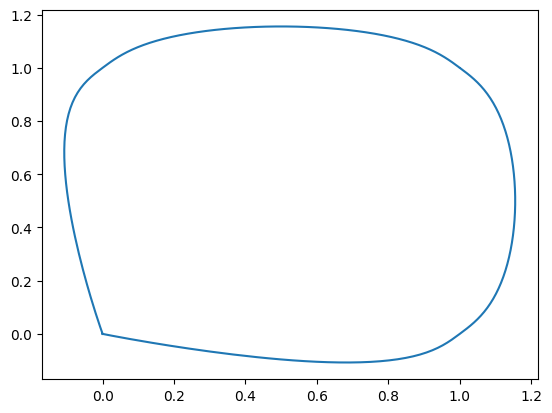

In [6]:
import numpy as np

n_dim = 2
k_time = 1e5  # weight on time
bc = np.array([# boundary conditions
    [
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 0],
    ],  # pos
    [
        [0, 0],
        [1, 1],
        [-1, 1],
        [-1, -1],
        [0, 0],
    ],  # vel
    [
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
    ],  # acc
])

assert bc.shape[1] - 1 == n_legs
f_cost = lambda T: sum([cost["f_J"](T, bc[:, :, d], k_time) for d in range(n_dim)])

T0 = [10] * n_legs


sol = scipy.optimize.minimize(
    fun=f_cost, x0=[10] * n_legs, bounds=[(0.1, 100)] * n_legs
)

T_opt = sol["x"]

print("T_opt", T_opt)

opt_x = cost["f_p"](T_opt, bc[:, :, 0], k_time)
opt_y = cost["f_p"](T_opt, bc[:, :, 1], k_time)


def plot_traj(deriv=0):
    traj_x = compute_trajectory(opt_x, T_opt, poly_deg=poly_deg, deriv=deriv)
    traj_y = compute_trajectory(opt_y, T_opt, poly_deg=poly_deg, deriv=deriv)
    plt.plot(traj_x["t"], traj_x["x"], label="x")
    plt.plot(traj_y["t"], traj_y["x"], label="y")
    plt.legend()


fig = plt.figure()
traj_x = compute_trajectory(opt_x, T_opt, poly_deg=poly_deg, deriv=0)
traj_y = compute_trajectory(opt_y, T_opt, poly_deg=poly_deg, deriv=0)
ax = fig.add_subplot(111)
ax.plot(traj_x["x"], traj_y["x"]);

In [7]:
opt_x

[0,
 0.0,
 0.0,
 7.824377367426159,
 -11.192660392995778,
 4.368283025569619,
 1,
 0.4970940671903397,
 0.0,
 -0.9941881343806802,
 0.4970940671903392,
 0.0,
 1,
 -0.4970940667621469,
 0.0,
 -5.029059332378531,
 7.543588998567797,
 -3.0174355994271185,
 0,
 -0.5439056567737873,
 0.0,
 3.2634339406427237,
 -4.351245254190299,
 1.6317169703213619]

In [8]:
opt_y

[0,
 0.0,
 0.0,
 -2.175622632573841,
 3.807339607004222,
 -1.6317169744303808,
 0,
 0.4970940671903397,
 0.0,
 5.0290593280966025,
 -7.543588992144905,
 3.0174355968579616,
 1,
 0.4970940667621469,
 0.0,
 -0.9941881335242932,
 0.4970940667621466,
 0.0,
 1,
 -0.5439056567737873,
 0.0,
 -6.736566059357276,
 10.6487547458097,
 -4.368283029678638]

In [9]:
T_opt

array([0.54390566, 0.49709407, 0.49709407, 0.54390566])